<a href="https://colab.research.google.com/github/PsorTheDoctor/artificial-intelligence/blob/master/modern_approach/zero_shot_learning/owl_vit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#OWL-ViT: Zero-shot object detection

In [ ]:
%pip install -q git+https://github.com/huggingface/transformers.git

In [81]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from transformers.utils import send_example_telemetry
from transformers import OwlViTProcessor, OwlViTForObjectDetection
from transformers.image_utils import ImageFeatureExtractionMixin

In [82]:
send_example_telemetry(
  'zeroshot_object_detection_with_owlvit_notebook', framework='pytorch'
)
model = OwlViTForObjectDetection.from_pretrained('google/owlvit-base-patch32')
processor = OwlViTProcessor.from_pretrained('google/owlvit-base-patch32')

In [120]:
path = '/content/image_dataset/'
file_list = sorted(os.listdir(path))

images = []
for filename in file_list:
  if filename[-4:] == '.jpg':
    img = Image.open(path + filename)
    images.append(img)

In [86]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [128]:
inputs = processor(text=['logo'], images=images[2], return_tensors="pt").to(device)

for key, val in inputs.items():
  print(f'{key}: {val.shape}')

input_ids: torch.Size([1, 16])
attention_mask: torch.Size([1, 16])
pixel_values: torch.Size([1, 3, 768, 768])


In [129]:
model = model.to(device)
model.eval()

with torch.no_grad():
  outputs = model(**inputs)

for k, val in outputs.items():
  if k not in {'text_model_output', 'vision_model_output'}:
    print(f'{k}: shape of {val.shape}')

print('\nText model outputs')
for k, val in outputs.text_model_output.items():
  print(f'{k}: shape of {val.shape}')

print('\nVision model outputs')
for k, val in outputs.vision_model_output.items():
  print(f'{k}: shape of {val.shape}')

logits: shape of torch.Size([1, 576, 1])
pred_boxes: shape of torch.Size([1, 576, 4])
text_embeds: shape of torch.Size([1, 1, 512])
image_embeds: shape of torch.Size([1, 24, 24, 768])
class_embeds: shape of torch.Size([1, 576, 512])

Text model outputs
last_hidden_state: shape of torch.Size([1, 16, 512])
pooler_output: shape of torch.Size([1, 512])

Vision model outputs
last_hidden_state: shape of torch.Size([1, 577, 768])
pooler_output: shape of torch.Size([1, 768])


In [132]:
mixin = ImageFeatureExtractionMixin()

image_size = model.config.vision_config.image_size
image = mixin.resize(images[2], image_size)
input_image = np.asarray(image).astype(np.float32) / 255.0

score_threshold = 0.003

logits = torch.max(outputs['logits'][0], dim=-1)
scores = torch.sigmoid(logits.values).cpu().detach().numpy()

labels = logits.indices.cpu().detach().numpy()
boxes = outputs['pred_boxes'][0].cpu().detach().numpy()

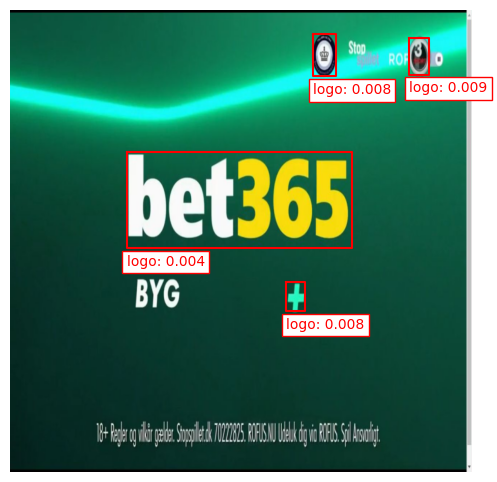

In [133]:
def plot_predictions(input_image, text_queries, scores, boxes, labels):
  fig, ax = plt.subplots(1, 1, figsize=(8, 6))
  ax.imshow(input_image, extent=(0, 1, 1, 0))
  ax.set_axis_off()

  for score, box, label in zip(scores, boxes, labels):
    if score < score_threshold:
      continue

    cx, cy, w, h = box
    ax.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
            [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], 'r')
    ax.text(
        cx - w / 2,
        cy + h / 2 + 0.015,
        f"{text_queries[label]}: {score:1.3f}",
        ha="left",
        va="top",
        color="red",
        bbox={
            "facecolor": "white",
            "edgecolor": "red",
            "boxstyle": "square,pad=.3"
    })

plot_predictions(input_image, ['logo'], scores, boxes, labels)